# I. Introduction 


The following document is a summary of my process of building text classifier pipelines that parses through 730 articles on Business Insider and extracts all entities in which it recognizes as one of three given types: CEOs, companies, and percentages. 

Based on provided label values for each of the three categories, a logistic regression model for each entity type was constructed to classify the words based the context of the sentence they are in. The CEO classifier, company classifier, and the percentage classifier models were run through a subset of entities from the corpus composing of all 730 articles. 

The goal of this project was to build the following models:
1.	**Classifier of names of CEOs in the corpus**
2.	**Classifier of company names in the corpus**
3.	**Classifier of entities involving percentages**

These models were 
- Trained on a set of positive samples (determined by provided label values) and subset of negative samples
- Evaluated on all entities extracted by `Spacy` 

The system parsed through a corpus of .txt files of total 730 Business Insider articles, taken from 2013 and 2014. The script is tailored to the format of these text files and will need to be adjusted if other articles are used. 

*** 

# II. Methodology

To build the CEO classifier, company classifier, and the percentage classifier, a script was written that follows this basic pipeline. Full code and walk through is available in this repo at **BI_Text_Classification_Code.ipynb**.

## A. Preparation 

The data came with 730 .txt files with Business Insider articles, shown below. 

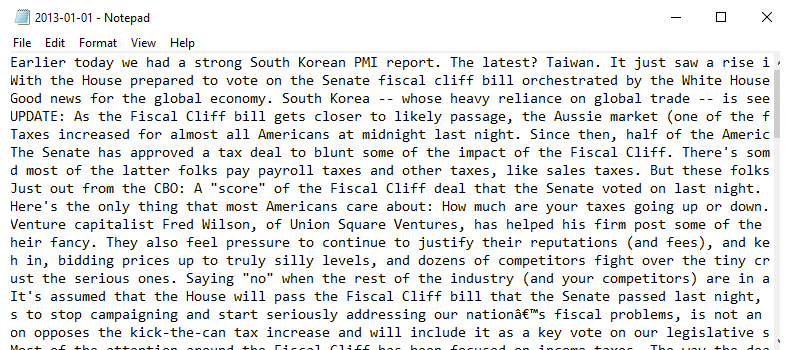

I imported the .txt files, combined all the text into one corpus, and stored the corpus as a list of sentences using the `nltk.sent_tokenizer` tool from the `nltk.tokenize` package. 

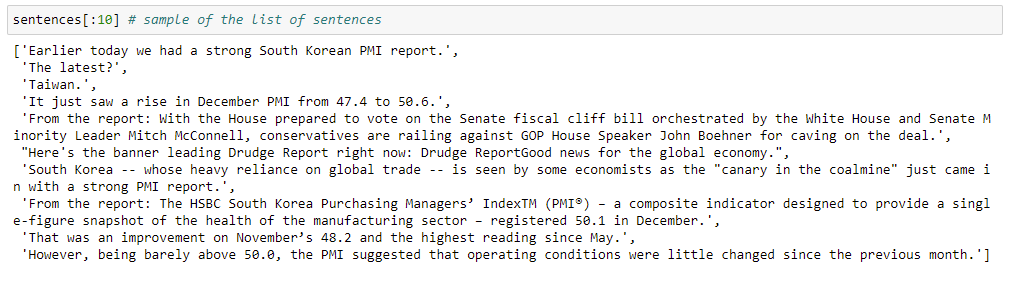

The data also came with labels, which are known values of CEO, companies, and percentages in the corpus, each in a separate file. 'ceo.csv', 'companies.csv', 'percentage.csv'. 
- The CEO labels came with two columns, First Name and Last Name, so the texts for each column were combined into one. I also removed any duplicates from these labels, and only stored ones that exist in the corpus. 
- No additional cleaning was needed for 'companies.csv' and 'percentage.csv'.

Because training sets are needed for each classifier, I needed both positive and negative samples for each classifier. 
- I was able to use the label data as positive samples (the entities that I know for sure are CEOs, companies, or percentages), and I needed to extract negative samples from the text. 
- I decided to incorporate the NER classifier tool in **spaCy**, a free open-source Python library for Natural Language Processing. 
- I ran the entire corpus into the **spaCy NER classifier** and stored all results that were identified as 
    - `PERSON`
    - `ORG`
    - `PERCENT` (entities classified as a percentage)
    - `CARDINAL` (entities classified as numeric that are not of any specific type)
- The entirety of the extracted entities was later used as a test set for model evaluation.

Then, I constructed **training instances for each classifier**. I created dataframes where each entity has its associated **sentence** and **label**. Features will be generated using the entity's associated sentence. 
- CEO classifier (3194 observations in training set)
    - Positive samples: 1194 entities in CEO label data (that exists in our corpus)
    - Negative samples: First 2000 entities classified as “PERSON” but not in the CEO label data
- Company classifier (2560 observations in training set)
    - Positive samples: 2560 entities in company label data (that exists in our corpus)
    - Negative samples: First 3000 entities classified as “ORG” but not in the company label data
- Percentage classifier (8234 observations in training set)
    - Positive samples: 3234 entities in percentage label data (that exists in our corpus)
    - Negative samples: First 5000 entities classified as “CARDINAL” but not in the company label data.


**Sample training instances for CEO Classifier**

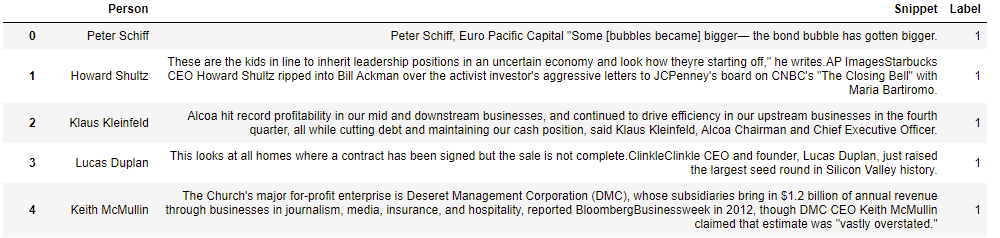



## B. Building Features

Each observation of the training data at this point contains three columns. 
- The entity (either a positive or a negative sample)
- the sentence in the corpus that it is in
- The label (1 = positive, 0 = negative). 

**Based on the text data, I constructed features that the logistic regression algorithm will use, with the help of Regular Expressions.** 

Most features are binary (1 = yes, 0 = no). Following are the features used for each classifier.
- CEO classifier (6 Features)
    - `hasCEO`: The entity’s associated sentence has the word “CEO”
	- `hasChiefExec`: The entity’s associated sentence has the word “Chief” or “Executive”
	- `hasPres`: The entity’s associated sentence has the word “President”
	- `hasChairman`: The entity’s associated sentence has the word “Chairman”
	- `hasFounder`: The entity’s associated sentence has the word “Founder”
	- `hasPossession`: The entity’s associated sentence has a “’s” directly following the entity
- Company Classifier (5 Features)
	- `hasSuffix`: The entity has words either Inc, Ltd, Co, LLC, Corp, Inc, or Group directly following it
	- `hasQuarter`: The entity’s associated sentence has the word “Quarter” (quarters, quarterly, etc count), or Q1/Q2/Q3/Q4
	- `hasDollar`: The entity’s associated sentence has the dollar sign
	- `hasKeyword`: The entity’s associated sentence has one of the following key words: “Company/ies,” “IPO,” “Stock,” “Dividend,” “President,” “Chairman” 
	- `numKeyword`: Number of how many above keywords are there in the entity’s associated sentence
- Percentage Classifier (6 Features)
	- `hasPercentS`: Has the symbol "%" following the entity in the sentence
	- `hasPercentW`: Has the word "percent" following the entity in the sentence
	- `hasNumPercS`: Extracted entity has the symbol % following a numerical character
	- `hasNumPercW`: Extracted entity has the word 'percent' following a numerical character
	- `hasWordPercS`: Extracted entity has the symbol % following numerical words
	- `hasNumPercW`: Extracted entity has the word 'percent' following numerical words

## C. Training/Testing Using Logistic Regression

After the above features have been added onto the training sets, I performed logistic regression and used a 80/20 training/test split to evaluate the performance metrics of my model. For each model, a **confusion matrix** and **precision/recall values** were calculated and outputted (See **III. Results**).

Then, I took each model and applied it to the entire corpus in order to obtain the final predictions. Because I could not apply this model to every single word in the corpus (that would take too long), I used the following subset of the words in the corpus for each entity type.
- CEO Classifier
    - Obtained classifications for all 178,642 entities classified as “PERSON” by the spaCy NER classifier
- Company Classifier
    - Obtained classifications for all 320,636 entities classified as “ORG” by the spaCy NER classifier
- Percentage classifier
    - Obtained classifications for total of 160,896 entities including the following.
    - 73,114 entities classified as “PERCENT” by the spaCy NER classifier
    - 87,782 entities classified as “CARDINAL” by the spaCy NER classifier (for these, only entities that are not in the original percent label were extracted).
    
Predictions were obtained, then the confusion matrix and the precision/recall rates were also calculated and outputted (See Results section)



***

# III. Results

The following table captures the following 
- Each instance of classification's 
    - **Accuracy**
    - **Recall**
    - **Recall Ratio** (Correctly Predicted Positives/All Positives)
    - **Precision**
    - **Precision Ratio** (Correctly Predicted Positives/All predicted positive)


In [12]:
import pandas as pd

classifier = ['CEO', 'CEO', 'Company', 'Company', 'Percentage', 'Percentage']
type_model = ['Train', 'Test','Train', 'Test','Train', 'Test']
accuracy = [0.86, 0.90, 0.61, 0.70, 0.81, 1.00]
recall = [0.7, 0.31, 0.38, 0.23, 0.56, 1]
recall_ratio = ['179/255', '4112/13075', '200/523', '16901/73484', '369/658', '72931/73114']
precision = [0.92, 0.32, 0.64, 0.3, 0.95, 0.99]
precision_ratio = ['176/195', '4112/12986', '200/314', '16901/56991', '369/388', '72931/73328']

pd.DataFrame(list(zip(classifier, type_model, accuracy, recall, recall_ratio, precision, precision_ratio)),
              columns=['Classifier', 'Type','Accuracy', 'Recall', 'Recall Ratio', 'Precision', 'Precision Ratio'])


,Classifier,Type,Accuracy,Recall,Recall Ratio,Precision,Precision Ratio
0,CEO,Train,0.86,0.70,179/255,0.92,176/195
1,CEO,Test,0.90,0.31,4112/13075,0.32,4112/12986
2,Company,Train,0.61,0.38,200/523,0.64,200/314
3,Company,Test,0.70,0.23,16901/73484,0.30,16901/56991
4,Percentage,Train,0.81,0.56,369/658,0.95,369/388
5,Percentage,Test,1.00,1.00,72931/73114,0.99,72931/73328


The CEO classifier performed relatively well in the training set with good precision and decent recall, but both of these values falls flat for the predictions across the entire text corpus. The Company classifier performed poorly for both precision and recall in the training set, and even worse for the test set. However, for the percentage classifier, the accuracy, recall, and precision improve by a lot for predictions, with almost a perfect score for each of the categories. Given that there are very clear contextual cues for an entity being a "percentage," it was relatively easier to build a percentage classifier. It is difficult to predict a CEO or Company with relatively few features. It is worth noting that most of the features used in these models had to do with the sentence that the entity was in, rather than dealing with the actual entity itself. 

For instance, in a hypothetical sentence “President Barack Obama spoke with Facebook CEO Mark Zuckerberg,” Barack Obama and Mark Zuckerberg would be the two entities that SpaCy would choose to classify. The feature “hasCEO” for both Barack Obama and Mark Zuckerberg would have the value 1, because the feature simply searches for the existence of the word “CEO” in the sentence. Because Zuckerberg would be labelled as a CEO and Obama not, this would confuse the logistic algorithm, because there are not too many features that distinguishes the word from its associated sentence. This could potentially lead to both low recall and precision rates, as both types of misclassifications can occur (true CEOs labelled as false, or false CEOs labelled as true). With the increasing volumes of samples, such misclassifications can amplify, dramatically lowering the precision and recall rates when the models are applied to the entire corpus. 

For the CEO/Company classifiers, the next steps to improve the models would be the following
- Introduce more and better features that captures more information about the position of the entity within the sentence, and the surrounding key words (so that entities in the same sentence could have different values for these features)
    - If a feature measured the positional distance between the entity being classified and the word “CEO,” Mark Zuckerberg would have a lower “distance” compared to Barack Obama for the example sentence above. 
- Adding more such features may lead to even greater overfitting.
    - Introduce regularization parameters, or try different classification methods (SGD, high bias random forest/ensemble methods) 
    - Train on more entities, not just the ones SpaCy selected. Train on more articles. 
- Add regularization to the model to address overfitting, as the metrics dramatically reduce when 

